# Part 2 Logistic Regression

In this part, we will implement a logistic regression classifier and train it with [fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) using stochastic gradient descent (SGD).

First, download the dataset.


In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
cd /content/drive/MyDrive/BLG561/DL_HW1/DL_HW1-student

/content/drive/MyDrive/BLG561/DL_HW1/DL_HW1-student


In [81]:
%load_ext autoreload
%autoreload 2

from typing import Tuple
import requests
import gzip
import numpy as np
import os
from dataclasses import dataclass

from src.logistic_regression import DataLoader, LogisticRegresssionClassifier
from src.logger import Logger


train_labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
train_images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
test_labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
test_images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"

os.makedirs("data", exist_ok=True)


def download_and_load(url: str, name: str, kind: str, offset: int) -> np.ndarray:
    file_path = f"data/{kind}_{name}"
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, "wb") as f:
            f.write(response.content)
    with gzip.open(file_path, "rb") as lbpath:
        return np.frombuffer(lbpath.read(), dtype=np.uint8, offset=offset)


train_labels = download_and_load(train_labels_url, "train", "labels", 8)
train_data = download_and_load(train_images_url, "train", "images",
                               16).reshape(len(train_labels), 784)
test_labels = download_and_load(test_labels_url, "test", "labels", 8)
test_data = download_and_load(test_images_url, "test", "images", 16).reshape(len(test_labels), 784)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Implementation

In this part, we will complete the ```LogisticRegresssionClassifier``` and ```DataLoader``` classes under the "src/logistic_regression.py" file. The classifier has two main methods, ```predict``` and ```fit```, similar to scikit API. Please take a look at ```fit``` method which is already completed. This method contains the main loop of the learning process.

We start the implementation with the data loader. Since we are using SGD, we need to partition the data into batches. Also, at the start of every epoch (a full pass of the data), we shuffle the data by randomly permuting it.

> Complete ```DataLoader``` by implementing ```shuffle``` and ```__next__``` methods.

**Note:** You may want to read this [article](http://www.trytoprogram.com/python-programming/python-iterators/) about ```__iter__``` method  

In [82]:
train_loader = DataLoader(train_data, train_labels, batch_size=32)
iterator = iter(train_loader)
batch_data, batch_label = next(iterator)
assert(batch_data.shape == (32, 784))
assert(batch_label.shape == (32,))

Now, we complete ```LogisticRegresssionClassifier``` starting with ```_initialize``` method. This method initiates the weights and biases of the classifier.

> Complete ```_initialize``` methods.


In [83]:
classifier = LogisticRegresssionClassifier(784, 10)
assert(classifier.weights.shape == (784, 10))
assert(classifier.bias.shape == (10,))

[[ 1.62434536e-02 -6.11756414e-03 -5.28171752e-03 ... -7.61206901e-03
   3.19039096e-03 -2.49370375e-03]
 [ 1.46210794e-02 -2.06014071e-02 -3.22417204e-03 ... -8.77858418e-03
   4.22137467e-04  5.82815214e-03]
 [-1.10061918e-02  1.14472371e-02  9.01590721e-03 ... -9.35769434e-03
  -2.67888080e-03  5.30355467e-03]
 ...
 [-1.59100029e-02  1.35792061e-02  2.36745509e-03 ...  1.36913654e-02
  -8.61182578e-03  1.73596577e-04]
 [ 1.08833707e-02 -1.87976764e-03 -9.95279931e-03 ...  8.27967301e-05
  -1.40978979e-02 -9.01000668e-03]
 [ 6.49262432e-03 -8.82639075e-03  8.93410296e-03 ...  6.44351003e-03
  -1.52143433e-02 -2.61701409e-03]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Loss function

In the classification task, we use conditional class probabilities $P(Y\vert X, \theta)$ where $\theta$ denotes the parameters. We use maximum likelihood estimation (MLE) to find the best fit for the training data. However, contrary to Linear Regression models, in Logistic Regression, it is not straightforward to calculate the best fitting parameter $\theta$ with non-iterative methods due to non-linearity at the end of the function. Therefore, we use Stochastic Gradient Descent to iteratively maximize the likelihood of the data. Please read [chapters 5.5 and 5.9 of Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html) for details.

Since SGD minimizes the objective and log is a monotonic function, we can use negative log-likelihood (NLL) loss to maximize the likelihood.

> Complete ```nll_loss``` methods.


In [84]:
pred_probs = np.ones((1, 5)) /5 
label = np.array([3])
assert(np.allclose(classifier.nll_loss(pred_probs, label), -np.log(pred_probs[0, 3])))

### Prediction

Next, we implement ```predict``` method to obtain conditional class probabilities $P(Y \vert X, \theta)$. In order to do that, we need to implement Softmax function that models a categorical distribution over the classes.

Before moving to implementation, calculate the jacobian of the softmax function $f(\bm{x}): \mathcal{R}^{n} \rightarrow \mathcal{R}^{n}$. You can upload an image of your solution or write it in latex.

> Calculate the jacobian of the softmax function

<!-- ![solution](softmax_jacobian.png) -->
<img src="softmax_jacobian.png" alt="drawing" width="400"/>

> Complete ```softmax``` method.

In [85]:
#print(np.ones((1, 5)) / 5)
#print((np.ones((1, 5)) / 5).shape)
#a = np.ones((1, 5))
#a[0][2] = 2
assert(np.allclose(classifier.softmax(np.ones((1, 5))), np.ones((1, 5)) / 5))
#assert(np.allclose(classifier.softmax(a), np.ones((1, 5)) / 5))

> Complete ```predict``` method.

In [87]:
assert(classifier.predict(next(iterator)[0]).shape == (32, 10))

Following that, we can implement accuracy metric functions.

> Complete ```accuracy``` and ```confusion_matrix``` methods.

In [88]:
assert(classifier.accuracy(np.array([0, 1, 0, 0]), np.array([0, 1, 0, 1])) == 0.75)
print(np.array([[2, 1], [0, 1]]))
assert((classifier.confusion_matrix(np.array([0, 1, 0, 0]), np.array([0, 1, 0, 1])) == np.array([[2, 1], [0, 1]])).all())

[[2 1]
 [0 1]]


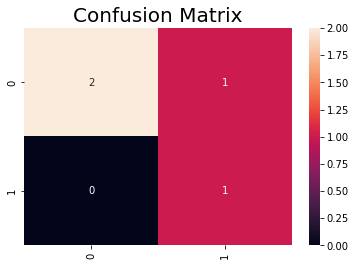

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix in a beautiful manner
ax= plt.subplot()
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()
plt.title('Confusion Matrix', fontsize=20)
ax.set_ylabel('True', fontsize=20)
plt.yticks(rotation=0)
cms = classifier.confusion_matrix(np.array([0, 1, 0, 0]), np.array([0, 1, 0, 1]))
sns.heatmap(cms, annot=True, ax = ax, fmt = 'g');
plt.savefig('part2_conf.png')
plt.show()

### Learning

Now that we completed the prediction and data loader parts, we can start completing the requisite methods for ```fit```. In order to update parameters, we need to calculate gradients of the loss function with respect to weights and biases.

> Implement ```nll_gradients``` method

In [90]:
label = np.array(1, dtype=np.int32)
inccorect_pred = np.zeros((1, 10), dtype=np.float32)
inccorect_pred[0, 0] = 1.0

correct_pred = np.zeros((1, 10), dtype=np.float32)
correct_pred[0, 1] = 1.0

inputs = np.ones((1, 784), dtype=np.float32)
weight_grad, bias_grad = classifier.nll_gradients(probs=correct_pred, inputs=inputs, labels=label)
assert((weight_grad == 0).all())
assert((bias_grad == 0).all())

weight_grad, bias_grad = classifier.nll_gradients(probs=inccorect_pred, inputs=inputs, labels=label)
assert((weight_grad[:, 0] == 1.0).all() and (weight_grad[:, 1] == -1.0).all() and (weight_grad[:, 2:] == 0.0).all())
assert((bias_grad[0] == 1.0) and (bias_grad[1] == -1.0) and (bias_grad[2:] == 0.0).all())


Finally, we need to implement the ```update``` method that updates the parameters with the given gradient and l2 regularization.

> Implement ```update``` method

In [91]:
prev_weights = classifier.weights.copy()
prev_bias = classifier.bias.copy()
print(prev_weights.shape)
print(prev_bias.shape)
classifier.update((np.ones_like(prev_weights), np.ones_like(prev_bias)), 1.0, 0.0)

assert(np.allclose(classifier.weights, prev_weights -1.0))
assert(np.allclose(classifier.bias, prev_bias -1.0))


(784, 10)
(10,)


Now that we finalized our implementation, we can train our classifier on the fashion MNIST dataset. Split the train data into train and eval sets and create ```train_loader``` and ```eval_loader```.

> Implement ```split_dataset``` function

In [92]:
def split_dataset(data: np.ndarray, label: np.ndarray, batch_size: int, train_ratio: float = 0.9
                  ) -> Tuple[DataLoader, DataLoader]:
    """ Split the data into train and eval sets

    Args:
        data (np.ndarray): Data array of shape (B, D)
        label (np.ndarray): Label array os shape (B)
        batch_size (int): Batch size of the dataloaders
        train_ratio (float): Ratio of the train sample size to overall sample size 

    Returns:
        Tuple[DataLoader, DataLoader]: Train and Eval Dataloaders
    """
    print(data.shape)
    print(label.shape)
    train_data, eval_data  = np.split(data, [int(0.9 * len(data))])
    train_label, eval_labels  = np.split(label, [int(0.9 * len(label))])
    train_loader = DataLoader(train_data, train_labels, batch_size=batch_size)
    eval_loader  = DataLoader(eval_data, eval_labels, batch_size=batch_size)
    return train_loader, eval_loader

@dataclass
class Hyperparameters():
    train_eval_ratio: float = 0.9
    batch_size: int = 32
    learning_rate: float = 1e-3
    l2_coeff: float = 1e-2
    epoch: int = 5


hyperparams = Hyperparameters()

train_loader, eval_loader = split_dataset(train_data, train_labels, hyperparams.batch_size)
logger = Logger(smooth_window_len=100, verbose=True, live_figure_update=True)
logger.render()


(60000, 784)
(60000,)


    'data': [{'mode': 'markers+lines',
              'name': 'accuracy',
       …

When you run the cell above, if you do not encounter any exception, you must see two empty plots side by side. When model ```fit``` function calls loggers ```log_iteration``` and ```log_epoch``` methods, these plots will be updated with the new values (given that logger is initailized with ```live_figure_update=True```). You can also use ```verbose``` option that allows logger to prints out the logs.

#### Start Training

You can start model training by running the cell below.

In [93]:
model = LogisticRegresssionClassifier(784, 10)
model.fit(train_loader,
          eval_loader,
          hyperparams.learning_rate,
          hyperparams.l2_coeff,
          hyperparams.epoch,
          logger)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
ACC =  0.90625
LOSS =  0.5233923864642838
ACC =  0.78125
LOSS =  0.4740009660661544
ACC =  0.875
LOSS =  0.5009014279056614
ACC =  0.8125
LOSS =  0.40548953730267157
ACC =  0.875
LOSS =  0.5593628999887488
ACC =  0.71875
LOSS =  0.7257777845068175
ACC =  0.84375
LOSS =  0.5524844312046118
ACC =  0.8125
LOSS =  0.5504006858833295
ACC =  0.75
LOSS =  0.3131197068663272
ACC =  0.875
LOSS =  0.3679275356640027
ACC =  0.84375
Epoch: 3, Iteration: 900, Train loss: 0.4547, Train acc: 0.8469
LOSS =  0.4470209168010096
ACC =  0.84375
LOSS =  0.5095600537527327
ACC =  0.84375
LOSS =  0.2901705544349514
ACC =  0.875
LOSS =  0.2847736432434463
ACC =  0.90625
LOSS =  0.3004396953194828
ACC =  0.875
LOSS =  0.2758754128954728
ACC =  0.90625
LOSS =  0.5320524223609142
ACC =  0.71875
LOSS =  0.4194600200710472
ACC =  0.875
LOSS =  0.3974525056658904
ACC =  0.875
LOSS =  0.6119370914481668
ACC =  0.84375
LOSS =  0.4577015568707489
ACC =  0.84375
LOSS =  0.

Hopefully, classifier fits the data with more than 80% evaluation accuracy. If so, you can run the model with the test data using the Test Loader and observe the confusion matrix in the test data.

> Implement ```test_classifier``` function

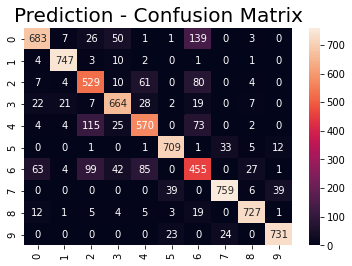

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
def test_classifier(data_loader: DataLoader, model: LogisticRegresssionClassifier) -> np.ndarray:
    """ Run the model with test data loader and return confusion matrix

    Args:
        data_loader (DataLoader): Data loader of the test data
        model (LogisticRegresssionClassifier): Trained classifier

    Returns:
        np.ndarray: Confusion matrix
    """
    # Plot confusion matrix in a beautiful manner
    ax= plt.subplot()
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()
    plt.title('Prediction - Confusion Matrix', fontsize=20)
    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)
    idx=0
    cms = np.zeros((10, 10))
    for test_data, test_label in data_loader:
      probs = model.predict(test_data)
      predictions = probs.argmax(axis=-1)
      cm = model.confusion_matrix(predictions, test_label)
      if cm.shape[0] == 10:
        cms += cm
    sns.heatmap(cms, annot=True, ax = ax, fmt = 'g');
    plt.savefig('prediction_cm.png')
    plt.show()
    return cms

test_loader = DataLoader(test_data, test_labels, hyperparams.batch_size)
confusion_matrix = test_classifier(test_loader, model)


> Lets run the cell below to plot ```confusion_matrix```

In [95]:
logger.render_confusion_matrix(confusion_matrix)